# Important Libraries

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,MaxAbsScaler,RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score,confusion_matrix,classification_report,ConfusionMatrixDisplay,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectKBest,chi2
from pandas.plotting import scatter_matrix
from scipy.stats import skew,chi2_contingency
import warnings
warnings.filterwarnings("ignore")

# Loading and Storing the dataset

In [2]:
train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

# Exploratory Data Analysis

**Train Data Analysis**

In [3]:
print(f"Shape:- {train.shape}")
print(f"Nan Values:-{train.isna().sum().sum()}")
train.head()

Shape:- (39211, 16)
Nan Values:-41483


,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [5]:
train.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [6]:
train.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


## Numerical Atrributes Analysis

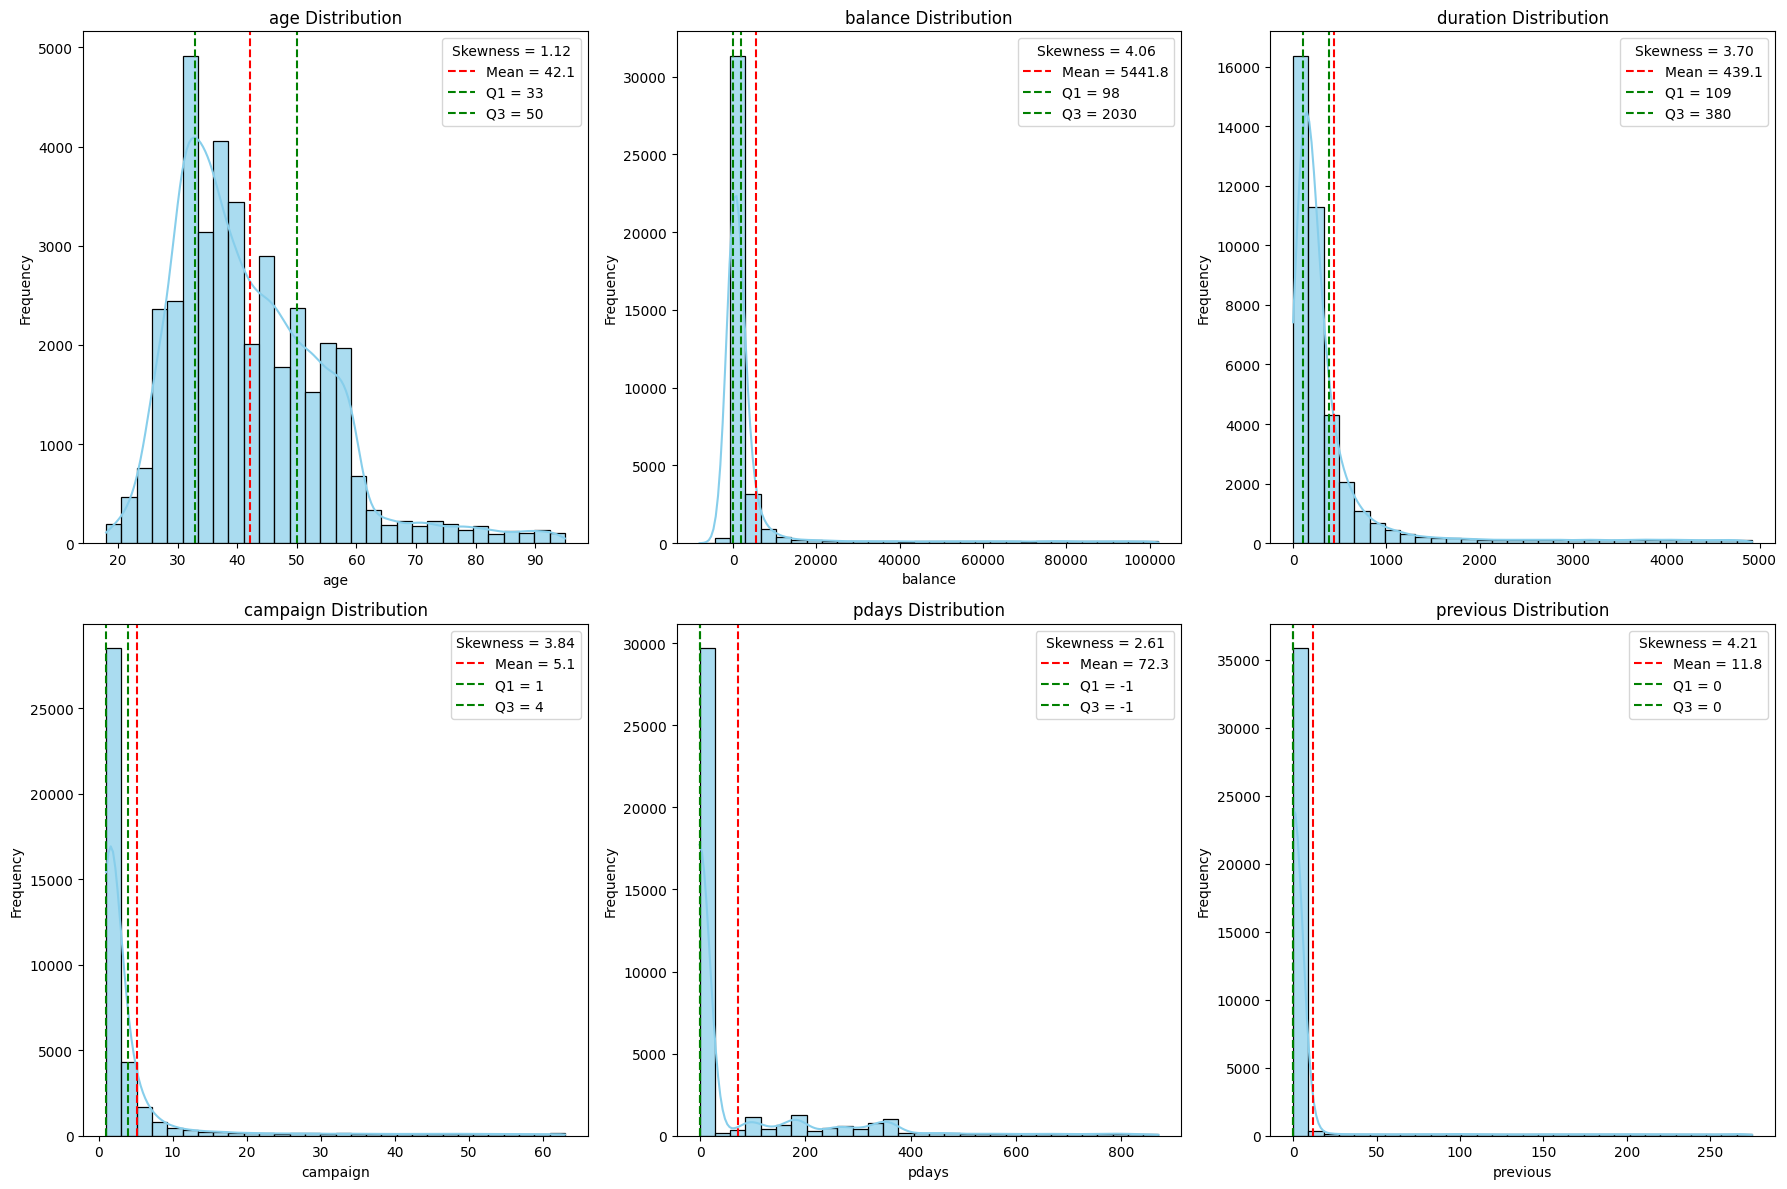

In [7]:

numerical_columns = train.select_dtypes(include=['number']).columns
n_cols = 3  
n_rows = math.ceil(len(numerical_columns) / n_cols)  # Calculate rows needed
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()
for idx, col in enumerate(numerical_columns):
    ax = axes[idx]
    mean_val = train[col].mean()
    q1_val = train[col].quantile(0.25)
    q3_val = train[col].quantile(0.75)
    skewness_val = skew(train[col].dropna(), nan_policy='omit')
    sns.histplot(train[col], kde=True, color='skyblue', bins=30, edgecolor='black', alpha=0.7, ax=ax)
    ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.1f}')
    ax.axvline(q1_val, color='green', linestyle='--', label=f'Q1 = {q1_val:.0f}')
    ax.axvline(q3_val, color='green', linestyle='--', label=f'Q3 = {q3_val:.0f}')
    ax.legend(title=f"Skewness = {skewness_val:.2f}")
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
for ax in axes[len(numerical_columns):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()


**Age Insight**.
* The data is slightly right-skewed with a skewness of 1.12, meaning there are more youngerclients and a smaller number of older ones

**Balance Insights**
* The distribution is highly right-skewed (skewness of 4.06), meaning a small number of clients have significantly higher balances.






ge).

In [8]:
# percentage of clients with negative balance, percecentage of clients with Zero balance
per_neg=train.loc[train['balance']<0].shape[0]/train.shape[0]*100
per_zero=train.loc[train['balance']==0].shape[0]/train.shape[0]*100
print(f'percentage of clients with negative balance: { per_neg:.2f}')
print(f'percecentage of clients with Zero balance: { per_zero:.2f}')

percentage of clients with negative balance: 7.58
percecentage of clients with Zero balance: 7.14


In [9]:
# percentage of new clients
prev_notcontacted=train.loc[train['pdays']==-1].shape[0]/train.shape[0]*100
print(f'percentage of new clients: {prev_notcontacted: .2f}')


percentage of new clients:  75.10


In [10]:
(train.loc[(train['pdays']==-1)& (train["previous"]==0)].shape[0]/train.shape[0])*100

75.09627400474356

**Insights from Pdays and Previous**

 Most clients (75%) were not contacted in previous campaigns, indicated by pdays = -1. For those previously contacted, the number of days ranges up to 871.
 
The data shows that `75%` of clients (`pdays = -1` and `previous = 0`) had no prior contact history, indicating they were new prospects. This highlights the bank's success in targeting and engaging `new clients` during the `current campaign`.

## Categorical Attributes Analysis

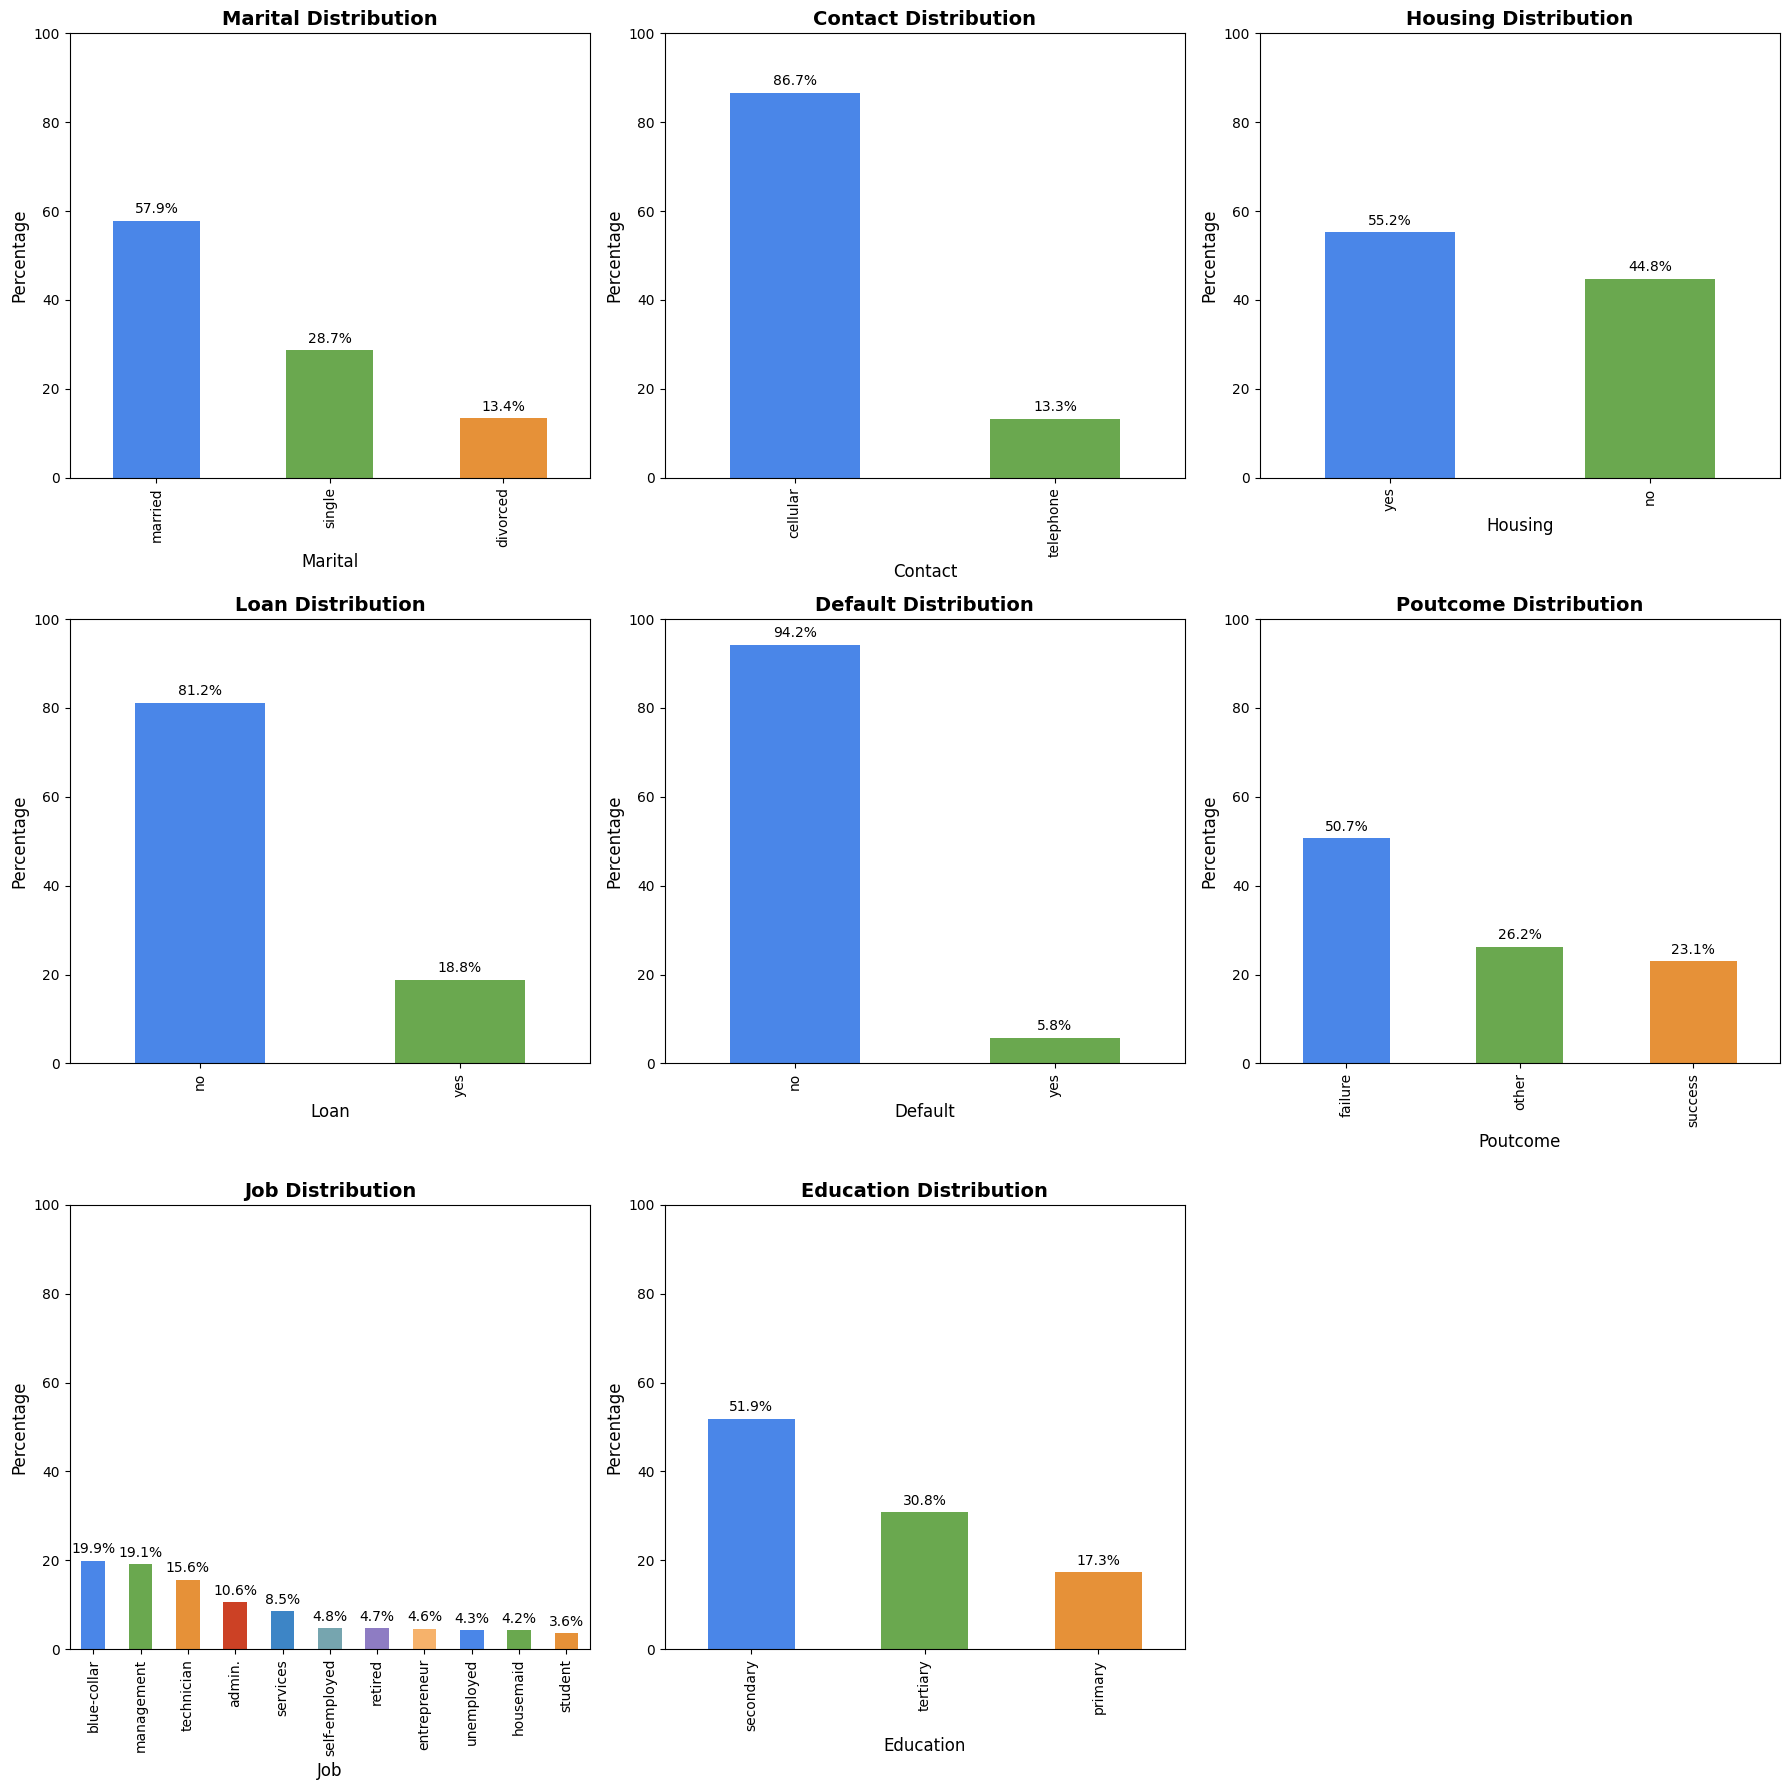

In [11]:

categories = ['marital', 'contact', 'housing', 'loan', 'default', 'poutcome', 'job', 'education']
colors = ['#4a86e8', '#6aa84f', '#e69138', '#cc4125', '#3d85c6', '#76a5af', '#8e7cc3', '#f6b26b']
n_cols = 3
n_rows = (len(categories) + n_cols - 1) // n_cols  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()
for i, category in enumerate(categories):
    category_counts = train[category].value_counts(normalize=True) * 100
    ax = axes[i]
    bars = category_counts.plot(kind='bar', color=colors[:len(category_counts)], ax=ax)
    ax.set_title(f'{category.capitalize()} Distribution', fontsize=14, fontweight='bold')
    ax.set_ylabel('Percentage', fontsize=12)
    ax.set_xlabel(category.capitalize(), fontsize=12)
    ax.set_ylim(0, 100)  
    for bar in bars.patches:
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_height() + 1,              
            f'{bar.get_height():.1f}%',        
            ha='center', va='bottom', fontsize=10, color='black'
        )
for ax in axes[len(categories):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()


**Categorical Attributes Insight**

Thbarie charts provide key demographic and financial insights:

1. **Marital Distribution:** A majority (57.9%) are married, followed by 28.7% single, and 13.4% divorced.
2. **Contact Distribution:** Most prefer cellular communication (86.7%), while only 13.3% use telephone.
3. **Housing Distribution:** 55.2% have housing loans, whereas 44.8% do not.
4. **Loan Distribution:** 81.2% do not have personal loans, while 18
5. **Job:** The most common professions in the dataset are blue-collar (19.8%), management (19%),
    and technician (15.5%)
6. **Education:** Most common education level is Secondary (51.9%).
7. **Default:** 5.8% clients are defaulters
8. **Poutcome:** Success rate of previous campaign is 23.1%...8% do.

These insights highlight marital status and financial commitments that can guide marketing or service customization strategies.

### Target

In [12]:
train["target"].value_counts(normalize=True)*100

target
no     85.139374
yes    14.860626
Name: proportion, dtype: float64

**Imbalanced Data Analysis**

The target variable in the dataset is significantly imbalanced:

- No (Negative Class): 85.14% of the samples.
- Yes (Positive Class): 14.86% of the samples.

This imbalance highlights the challenge of ensuring fair model performance across both classes. Without proper handling, a model might bias predictions toward the majority class ("No") while underperforming on the minority class ("Yes").

## Correlation Analysis of numerical attributes

**HeatMap Analysis**

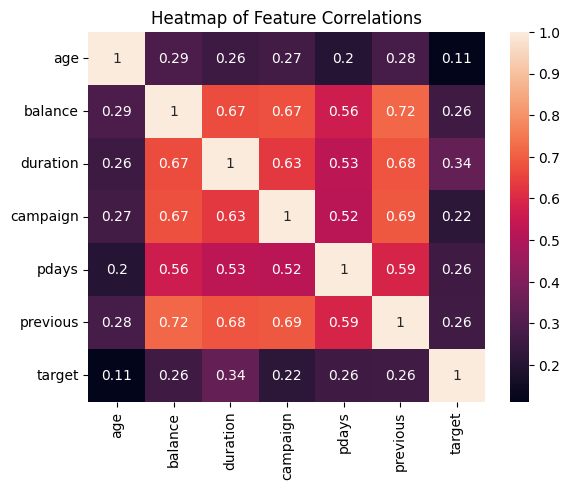

In [13]:
numerical_cols = train.select_dtypes(include=np.number).columns
train['target']=train['target'].replace({'yes':1,'no':0})
train_num=train.select_dtypes(np.number)
heat_map=sns.heatmap(train_num.corr(),annot=True)
plt.title('Heatmap of Feature Correlations')
plt.show()

**Important insights:**
1. **Balance and Previous Contact:** There is a strong positive correlation (0.72) between balance and previous, indicating that individuals with a higher account balance are likely to have been contacted previously.

2. **Balance and Duration:** A high correlation (0.67) between balance and duration suggests that individuals with larger balances tend to have longer durations of engagement during calls.

3. **Duration and Target:** Duration has a moderate correlation (0.34) with target, indicating that longer call durations slightly increase the likelihood of achieving the desired outcome (conversion or target success).

4. **Previous and Campaign:** There is a moderately strong correlation (0.69) between previous and campaign, implying that individuals contacted multiple times in previous campaigns are also likely to be contacted frequently in the current campaign.

5. **Balance and Campaign:** Balance and campaign have a notable correlation (0.67), showing that individuals with higher balances are targeted more frequently in campaigns.

## Correlation analysis for Categorical Analysis

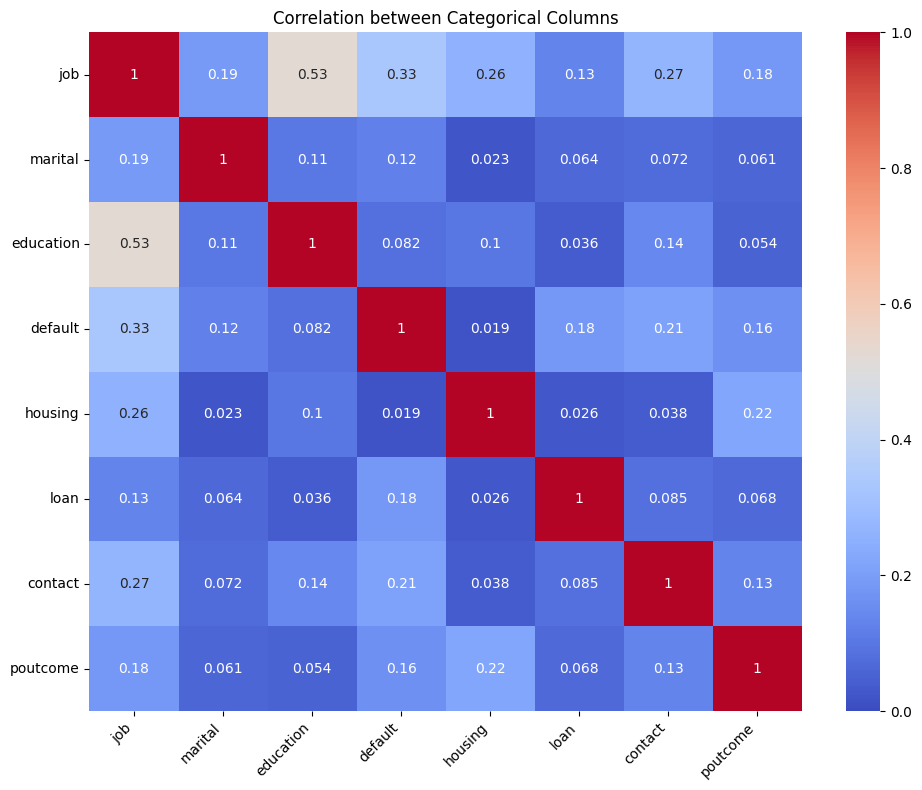

In [14]:
def cor_str(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))
categorical_columns = ['job', 'marital', 'education', 'default',
                       'housing', 'loan', 'contact', 'poutcome']
corr_matrix = np.zeros((len(categorical_columns), len(categorical_columns)))
for i in range(len(categorical_columns)):
    for j in range(len(categorical_columns)):
        corr_matrix[i, j] = cor_str(train[categorical_columns[i]], train[categorical_columns[j]])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=categorical_columns, yticklabels=categorical_columns, vmin=0, vmax=1)
plt.title('Correlation between Categorical Columns')
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0) 
plt.tight_layout() 
plt.show()


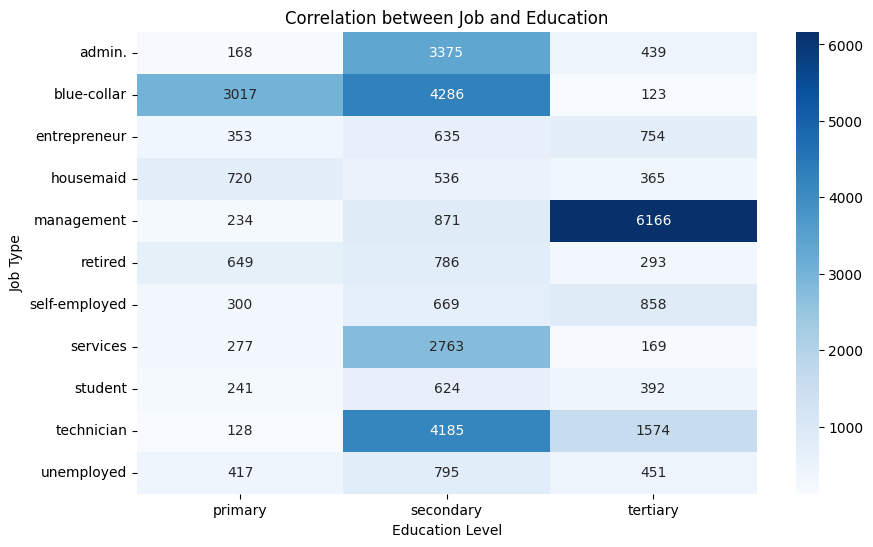

In [15]:
# contingency table between 'job' and 'education'
cross_tab = pd.crosstab(train['job'], train['education'])
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap="Blues", fmt="d")
plt.title("Correlation between Job and Education")
plt.xlabel("Education Level")
plt.ylabel("Job Type")
plt.show()


**Correlation Analysis between Job and Education**

The contingency table provides a clear correlation between `job types` and `education levels`, making it useful for imputing missing values.
For instance,
* Individuals with `secondary education` are most likely in `blue-collar` jobs (4286).
* Those with `tertiary education` often work in `management` (6166).
* `Primary education` aligns strongly with `blue-collar` roles (3017).

These patterns can guide accurate imputation of missing job or education data.

## Detecting Outliers

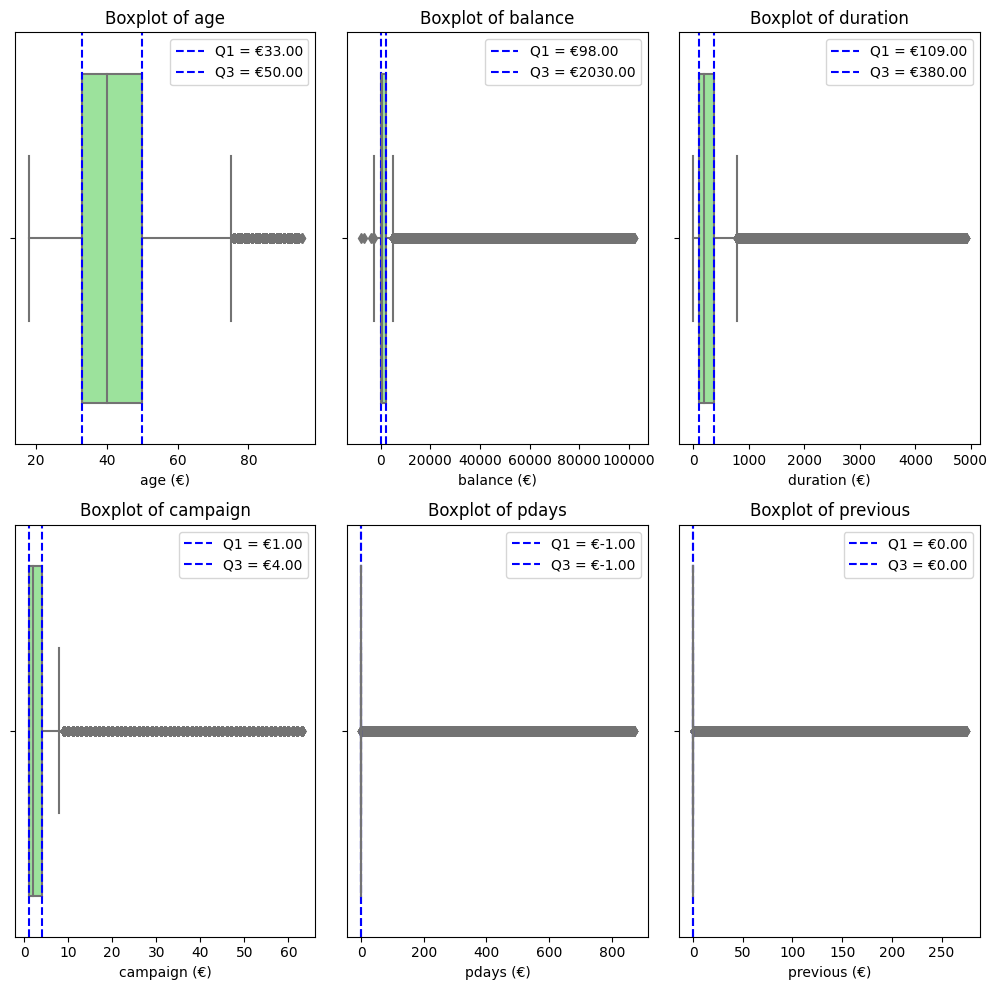

In [16]:

# Extract numerical columns
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
# Set up the subplot grid (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
axes = axes.flatten()

# Iterate over numerical columns
for i, col in enumerate(numerical_cols):
    # Calculate Q1 and Q3
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)

    # Plot boxplot
    sns.boxplot(x=train[col], color='lightgreen', ax=axes[i])
    axes[i].axvline(q1, color='blue', linestyle='--', label=f'Q1 = €{q1:.2f}')
    axes[i].axvline(q3, color='blue', linestyle='--', label=f'Q3 = €{q3:.2f}')
    axes[i].legend()
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(f'{col} (€)')

# Remove empty subplots if there are fewer columns than 6
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


**Boxplot Analysis**

The boxplots effectively highlight outliers across various variables. Significant outliers are observed in `balance`, `duration`, and `campaign`, as their values exceed the upper whisker limits. For instance, `balance` shows extreme values beyond €20,030 (Q3). Similarly, `pdays` and `previous` are heavily skewed, indicating potential data irregularities or rare events. These outliers require careful treatment to avoid skewed analysis.

# Data Preprocessing

### Handling missing values and imputations

**Training Data Imputation**

In [17]:
# cat_col1 = ["contact","job", "education", "poutcome"]
# cat_col2 = ["marital", "housing","default", "loan"]
# num_col = train.select_dtypes(include=["int64"]).columns
# cat_transformer1 = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
#                                    ("onehot", OneHotEncoder(sparse_output=False))])
# cat_transformer2 = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False))])
# num_transformer = Pipeline(steps=[("scaler", MinMaxScaler())])


In [18]:
train.loc[(train['job']=="management") & (train["education"].isna()),'education']="tertiary"
train.loc[(train['job']=="technician")& (train["education"].isna()),'education']="secondary"
train.loc[(train['job']=="blue-collar") & (train["education"].isna()),'education']="secondary"
train.loc[(train['job']=="admin.") & (train["education"].isna()),'education']="secondary"
train.loc[(train['job']=="services") &  (train["education"].isna()),'education']="secondary"
train.loc[(train['job']=="self-employed") & (train["education"].isna()),'education']="tertiary"
train.loc[(train['job']=="entrepreneur") & (train["education"].isna()),'education']="tertiary"
train.loc[(train['job']=="student") & (train["education"].isna()),'education']="secondary"
train.loc[(train['job']=="retired") & (train["education"].isna()),'education']="secondary"
train.loc[(train['job']=="unemployed") & (train["education"].isna()),'education']="secondary"
train.loc[(train['job']=="housemaid") & (train["education"].isna()),'education']="primary"
train.loc[(train["job"].isna()) & (train["education"].isna()),"job"]="blue-collar"
train.loc[(train['job']=="blue-collar") & (train["education"].isna()),'education']="secondary"
train.loc[(train["contact"].isna()),"contact"]="cellular"
train.loc[(train["poutcome"].isna()),"poutcome"]="unknown"
train.loc[(train['education']=="primary") & (train["job"].isna()),"job"]="housemaid"
train.loc[(train['education']=="secondary") & (train["job"].isna()),"job"]="blue-collar"
train.loc[(train['education']=="tertiary")& (train["job"].isna()),"job"]="management"

Missing values in the dataset were imputed based on logical relationships derived from the correlation between job type and education level (refer to the heatmap):

1. **Education Imputation:**
  Missing education was filled based on job type:
 - management → "tertiary"
 - blue-collar, services, technician, retired → "secondary"
 - housemaid → "primary"

2. **Job Imputation:**
  Missing job was filled based on education level:
 - "tertiary" → management
 - "secondary" → blue-collar
 - "primary" → housemaid

3. **Simultaneous Missing Job and Education:**
 Imputed as blue-collar for job and "secondary" for education.
4. **Other Columns:**
 * Missing `contact` was set to "cellular".
 *  `poutcome` has missing values for those customers who are not previously contacted(`New prospects`). Imputing values as `failure` or `success` in the poutcome column is not appropriate, as it would misrepresent customers who were never contacted in a previous campaign. Labeling these customers as `success` or `failure` could introduce bias and lead to misleading conclusions. Instead, imputing these values as `unknown` is more accurate and reflects their status appropriately.

 This approach preserves consistency and reflects observed patterns in the data.

**Test Data Imputation**

In [19]:
test.drop(columns=["last contact date"],inplace=True)
test.loc[(test['job']=="management") & (test["education"].isna()),'education']="tertiary"
test.loc[(test['job']=="technician")& (test["education"].isna()),'education']="secondary"
test.loc[(test['job']=="blue-collar") & (test["education"].isna()),'education']="secondary"
test.loc[(test['job']=="admin.") & (test["education"].isna()),'education']="secondary"
test.loc[(test['job']=="services") &  (test["education"].isna()),'education']="secondary"
test.loc[(test['job']=="self-employed") & (test["education"].isna()),'education']="tertiary"
test.loc[(test['job']=="entrepreneur") & (test["education"].isna()),'education']="tertiary"
test.loc[(test['job']=="student") & (test["education"].isna()),'education']="secondary"
test.loc[(test['job']=="retired") & (test["education"].isna()),'education']="secondary"
test.loc[(test['job']=="unemployed") & (test["education"].isna()),'education']="secondary"
test.loc[(test['job']=="housemaid") & (test["education"].isna()),'education']="primary"
test.loc[(test["job"].isna()) & (test["education"].isna()),"job"]="blue-collar"
test.loc[(test['job']=="blue-collar") & (test["education"].isna()),'education']="secondary"
test.loc[(test["contact"].isna()),"contact"]="cellular"
test.loc[(test["poutcome"].isna()),"poutcome"]="unknown"
test.loc[(test['education']=="primary") & (test["job"].isna()),"job"]="housemaid"
test.loc[(test['education']=="secondary") & (test["job"].isna()),"job"]="blue-collar"
test.loc[(test['education']=="tertiary")& (test["job"].isna()),"job"]="management"

In [20]:
train['target']=train['target'].replace({1:'yes',0:'no'})
ytrain=train["target"]
train.drop(columns=["target","last contact date"],inplace=True)

cat=train.select_dtypes(object).columns
num=train.select_dtypes(np.number).columns

## Encoding and Scalling

In [21]:
cat_encode=Pipeline(steps=[('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])


num_std=Pipeline(steps=[('scaler',MinMaxScaler())])
preprocessor=ColumnTransformer(transformers=[('cat_encode',cat_encode,cat),
                                              ('num_std',num_std,num),
                                              ],verbose_feature_names_out=False,remainder='passthrough').set_output(transform='pandas')

1. **One-Hot Encoding:** I Used this for nominal variables to prevent introducing ordinal assumptions and avoid bias in the model.

2. **RobustScaler:** I Used this for Scaling the numerical as it ensurs no information loss and maintaining model performance.


In [22]:
trainX,validationX,trainy,validationy=train_test_split(train,ytrain,test_size=0.3,random_state=42,stratify=ytrain)
#Training Set preprocessing
trainX=preprocessor.fit_transform(trainX)
#Validation Set Transformation
validationX=preprocessor.transform(validationX)

I Splitted The training data in `Traning Set` and `Validation Set`.

Fitted the preprocessor on `Traning Set`.

In [23]:
# Actual Test data Transformation
new_test=preprocessor.transform(test)

## Feature Engineering :


In [24]:
# select_k_best = SelectKBest(score_func=chi2).set_output(transform="pandas")
# param_grid = {
#     'k': [10,15,20,25,30]
# }
# grid_search = GridSearchCV(select_k_best, param_grid, cv=5,scoring='f1_macro')
# grid_search.fit(trainX, trainy)
# print("Best value of K found: ", grid_search.best_params_)
# X_train_selected = grid_search.best_estimator_.transform(trainX)
# X_test_selected = grid_search.best_estimator_.transform(validationX)
# print(f"Shape of selected training data: {X_train_selected.shape}")
# print(f"Shape of selected test data: {X_test_selected.shape}")


The application of chi-square-based feature selection resulted in a drop in F1 score, likely due to the loss of critical feature information that contributes to model performance. Hence, retaining the full feature set was deemed more effective for achieving optimal results.

# Model building

## Model: Decision Tree

In [25]:
dtc=DecisionTreeClassifier(splitter='best',min_samples_split= 8,min_samples_leaf= 5,max_features = None,max_depth = 3, criterion = 'entropy',random_state=42)
dtc.fit(trainX,trainy)


DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       min_samples_split=8, random_state=42)

In [26]:
f1score=f1_score(validationy,dtc.predict(validationX),average='macro')
print(f1score)

0.7317972059543109


In [27]:
DTclassification_report=classification_report(validationy,dtc.predict(validationX))
print(DTclassification_report)

              precision    recall  f1-score   support

          no       0.92      0.93      0.92     10016
         yes       0.57      0.51      0.54      1748

    accuracy                           0.87     11764
   macro avg       0.75      0.72      0.73     11764
weighted avg       0.86      0.87      0.87     11764



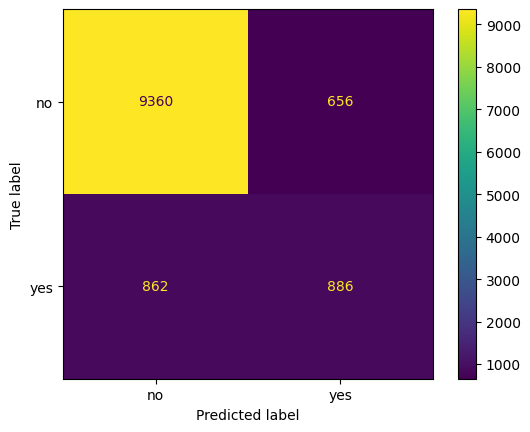

In [28]:
ConfusionMatrixDisplay.from_estimator(dtc,validationX,validationy)
plt.show()

## Model: SGD

In [29]:
sgd=SGDClassifier(loss='log_loss',max_iter=1000,random_state=42,penalty='elasticnet',early_stopping=True)
sgd.fit(trainX,trainy)

SGDClassifier(early_stopping=True, loss='log_loss', penalty='elasticnet',
              random_state=42)

In [30]:
f1score=f1_score(validationy,sgd.predict(validationX),average='macro')
print(f1score)

0.635059516547866


In [31]:
sgdclassification_report=classification_report(validationy,sgd.predict(validationX))
print(sgdclassification_report)

              precision    recall  f1-score   support

          no       0.88      0.97      0.92     10016
         yes       0.60      0.24      0.35      1748

    accuracy                           0.86     11764
   macro avg       0.74      0.61      0.64     11764
weighted avg       0.84      0.86      0.84     11764



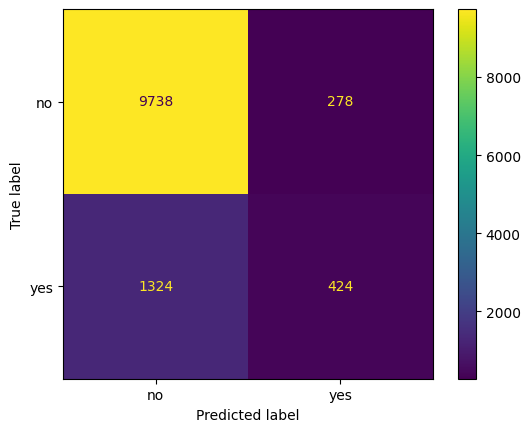

In [32]:
ConfusionMatrixDisplay.from_estimator(sgd,validationX,validationy)
plt.show()

## Model: SVM

In [33]:
svc = SVC(class_weight="balanced", gamma= 'scale',kernel='linear')
svc.fit(trainX,trainy)


SVC(class_weight='balanced', kernel='linear')

In [34]:
f1score=f1_score(validationy,svc.predict(validationX),average='macro')
print(f1score)

0.7376153865519113


In [35]:
svmclassification_report=classification_report(validationy,svc.predict(validationX))
print(svmclassification_report)

              precision    recall  f1-score   support

          no       0.94      0.87      0.91     10016
         yes       0.49      0.69      0.57      1748

    accuracy                           0.85     11764
   macro avg       0.71      0.78      0.74     11764
weighted avg       0.87      0.85      0.86     11764



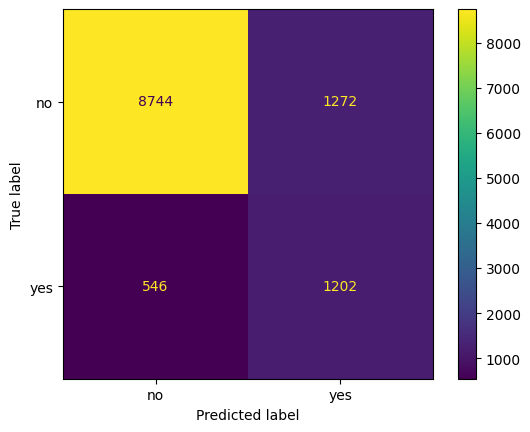

In [36]:
ConfusionMatrixDisplay.from_estimator(svc,validationX,validationy)
plt.show()

## Hyperparameter Tuning On SVC

I started by evaluating three baseline models—SVC, SGDClassifier, and DecisionTreeClassifier—achieving f1 score of 0.7376, 0.6350, and 0.7317, respectively. SVC showed the best performance among the three. Based on these results, I will now focus on tuning the SVC model to optimize its performance further, using techniques such as hyperparameter tuning.

0.0001
0.001
0.01
0.1
0.5
1
5
10
15
20


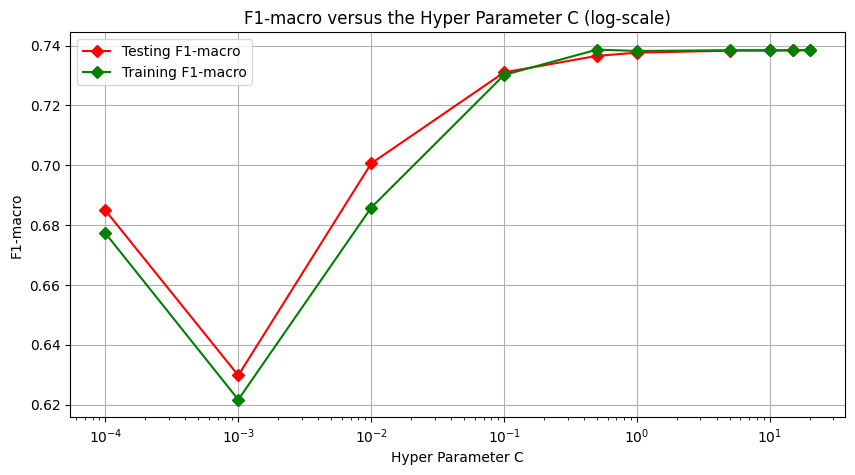

[0.6849213986775498, 0.6297638390823306, 0.7005969570567117, 0.7310322627873371, 0.7365543689728051, 0.7376153865519113, 0.7382875639137734, 0.7383845018689303, 0.7383845018689303, 0.7383854268533407]


In [37]:
f1_macro = []
f1_macro_tr = []
coefficient = []
C = [0.0001, 0.001, 0.01, 0.1,0.5, 1,5, 10,15,20]

for c in C:
    svm = SVC(class_weight="balanced",C=c ,gamma= 'scale',kernel='linear')
    svm.fit(trainX,trainy)

    p_tr = svm.predict(trainX)
    f1_tr = f1_score(trainy.ravel(), p_tr, average='macro')

    pred = svm.predict(validationX)
    f1 = f1_score(validationy.ravel(), pred, average='macro')
    print(c)
    f1_macro_tr.append(f1_tr)
    f1_macro.append(f1)

plt.subplots(figsize=(10, 5))
plt.semilogx(C, f1_macro, '-gD', color='red', label="Testing F1-macro")
plt.semilogx(C, f1_macro_tr, '-gD', label="Training F1-macro")
plt.grid(True)
plt.xlabel("Hyper Parameter C")
plt.ylabel("F1-macro")
plt.legend()
plt.title('F1-macro versus the Hyper Parameter C (log-scale)')
plt.show()
print(f1_macro)

## **Checking Model Performance with Bagging:**

**Applying an Ensemble Approach to Optimized SVC**

In [38]:
# bc = BaggingClassifier(SVC(class_weight="balanced",C=5, gamma= 'scale',kernel='linear',probability=True))
# bc.fit(trainX,trainy)

In [39]:
# f1score=f1_score(validationy,bc.predict(validationX),average='macro')
# print(f1score)

## **Enhancing Model Performance with BalancedBagging:**

**Applying an Ensemble Approach to Optimized SVC**

In [40]:
bbc = BalancedBaggingClassifier(SVC(class_weight="balanced", C = 5 ,kernel='linear'),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [41]:
bbc.fit(trainX,trainy)

BalancedBaggingClassifier(estimator=SVC(C=5, class_weight='balanced',
                                        kernel='linear'),
                          random_state=0)

In [42]:
f1score=f1_score(validationy,bbc.predict(validationX),average='macro')
print(f1score)

0.7415472764980893


In [43]:
bbc_classification_report=classification_report(validationy,bbc.predict(validationX))
print(bbc_classification_report)

              precision    recall  f1-score   support

          no       0.94      0.88      0.91     10016
         yes       0.50      0.67      0.57      1748

    accuracy                           0.85     11764
   macro avg       0.72      0.78      0.74     11764
weighted avg       0.87      0.85      0.86     11764



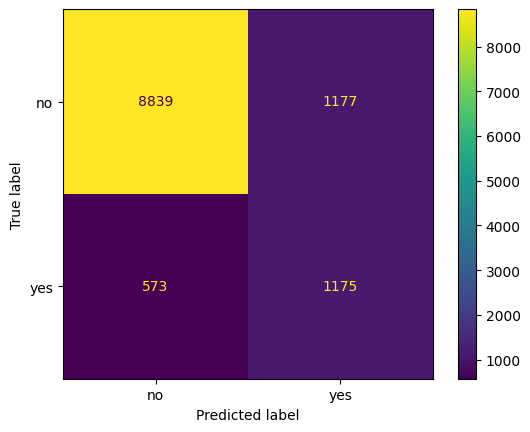

In [44]:
ConfusionMatrixDisplay.from_estimator(bbc,validationX,validationy)
plt.show()

## Model Comparison

**Model Comparison Table (on Validation Set)**

| Model                        | F1 Score | Notes                                                                                 |
|------------------------------|----------|---------------------------------------------------------------------------------------|
| Balanced Bagging Classifier  | **0.7415** | Best performance; effectively addresses class imbalance through balanced sampling.    |
| SVC                          | 0.7382   | Strong performance; |
| Decision Tree Classifier     | 0.7317   | Decent performance; likely overfitting due to the model's tendency to memorize data.        |
ng. |


# Important ideas


### **Key Data Insights**

1. **Demographics**:
   - Average client age: 42 years, with most clients aged 33–50.
   - Predominant jobs: blue-collar (19.8%), management (19%), and technician (15.5%).
   - Majority are married (57.9%) and prefer cellular communication (86.7%).

2. **Financial Insights**:
   - Mean balance: €5,441, but highly skewed due to a small number of wealthy clients.
   - 7.6% of clients have negative balances, and 7.1% have no savings.

3. **Campaign Activity**:
   - Median call duration: 197 seconds; longer calls moderately improve success rates.
   - 75% of clients have no prior contact history (pdays = -1).
   - Campaigns typically involve 2–4 contacts, but some clients are contacted excessively (up to 63 times).

4. **Target Imbalance**:
   - The dataset is highly imbalanced:
     - **No**: 85.1% (33,384 records)
     - **Yes**: 14.9% (5,827 records)

### **Correlations**:
1. **Balance and Engagement**:
   - Clients with higher balances are contacted more often and have longer calls.
2. **Duration and Target**:
   - Longer call durations are moderately linked to higher conversion success.

### **Actionable Insights**:
- Focus campaigns on younger clients and those with higher balances.
- Optimize call durations to improve conversion rates.


### **Most Important Insights from Model Performance**

1. **Baseline Model Comparison**:
   - SVC outperformed other models with an F1 macro score of **0.7376**, making it the best-performing baseline.
   - Decision Tree achieved a comparable F1 score of **0.7318**, while SGDClassifier lagged behind at **0.6356**.

2. **Hyperparameter Tuning (SVC)**:
   - Regularization parameter \( C \) was tuned over a range of values \([0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 15, 20]\).
   - The **best validation F1 score** of **0.7384** was achieved with \( C = 20 \).

3. **Enhancing Performance with Bagging**:
   - BalancedBaggingClassifier (BBC) was applied to the optimized SVC with \( C = 20 \) and linear kernel.
   - BBC further improved performance, achieving:
     - **Validation F1 score**: **0.7414**.
     - **Test F1 score**: **0.75289** on unseen data, indicating robust generalization.

4. **Actionable Insights**:
   - SVC is highly effective for the dataset, particularly when combined with techniques like **balanced bagging** to mitigate class imbalance.
   - Hyperparameter tuning and ensemble methods are essential to boosting performance and ensuring better generalization on unseen data.


# Final Model Submission

Based on the evaluation of the models, the `BalancedBaggingClassifier` achieved the highest `F1-macro` score. Therefore, I have selected it for the final submission.

In [45]:
y_pred=bbc.predict(new_test)

In [46]:

submission = pd.DataFrame({"id": range(0,new_test.shape[0]),
                           "target": y_pred})

submission.to_csv('submission.csv',index=False)